In [15]:
# ToDo:
# 1. cut post codes to first 2 digits +
# 2. move all rare cars to separate category (rare < 5 mark records) +
# 3. convert categorical variables with onehot/labelencoding +
# 4. add indicator variables for default variables +
# 5. Drop correlated features
# 6. Set type of all categorical coll to categorical

# Maybe:
# 1. Remove from train data records that can't be in test (marque of cars, regions)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import accuracy_score

import xgboost as xgb

%matplotlib inline
plt.style.use('ggplot')
random_state = 42

In [17]:
num_cols = ['annee_naissance', 'annee_permis', 'puis_fiscale', 'anc_veh', 'kmage_annuel', 'crm', 'var1', 'var2', 'var3', \
            'var4', 'var5', 'var9', 'var10', 'var11', 'var12', 'var13', 'var15', 'var17', 'var18', 'var19', 'var20', \
            'var21', 'var22', 'codepostal']
cat_cols = ['marque', 'energie_veh', 'profession', 'var6', 'var7', 'var8', 'var14', 'var16']
unused = []


def metric(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))


def prepare_data(df):
    # TODO: Find better way to deal NaN variables
    df.fillna(0, inplace=True)
    
    # codepostal
    # 1. Replace char records to 0
    # 2. Replace post codes to first 2 digits
    # 3. Convert to categorical type ???
    df['codepostal'] = df['codepostal'].apply(lambda it: 0 if not str(it).isdigit() else it)
    df['codepostal'] = df['codepostal'].apply(lambda it: int(str(it)[:2]))
#     df['codepostal'] = df['codepostal'].astype('category')
    
    # drop correlated features
#     features_to_drop = ['']

    # add indicator variables for default variables
    
    df['def_anc_veh'] = df['anc_veh'].apply(lambda it: 1 if it==99 else 0)
    df['def_var9'] = df['var9'].apply(lambda it: 1 if it==0 else 0)
    df['def_var10'] = df['var10'].apply(lambda it: 1 if it==0 else 0)
    df['def_var11'] = df['var11'].apply(lambda it: 1 if it==99 else 0)
    df['def_var12'] = df['var12'].apply(lambda it: 1 if it==3211 else 0)
    
    df['def_kmage_annuel'] = df['kmage_annuel'].apply(lambda it: 1 if it<17000 else 0)
    
    # test items
#     df[df['kmage_annuel']<17000]['def_kmage_annuel'] = 3
#     df[df['kmage_annuel']<10000]['def_kmage_annuel'] = 2
#     df[df['kmage_annuel']<5000]['def_kmage_annuel'] = 1
#     df['def_var18_less'] = df['var18'].apply(lambda it: 1 if it < 20 else 0)
    
#     df['puis_fiscale_sqrt'] = np.sqrt(df['puis_fiscale'])
#     df['puis_fiscale_sq'] = np.square(df['puis_fiscale'])
    
    return df

def prepare_num_data(df):
    return preprocessing.scale(df)

In [18]:
data = pd.read_csv('./data/ech_apprentissage.csv', sep=';', index_col='id')
test_data = pd.read_csv('./data/ech_test.csv', sep=';', index_col='id')

data_num = data[num_cols]
test_data_num = test_data[num_cols]

data_cat = data[cat_cols]
test_data_cat = test_data[cat_cols]

## Prepare numerical variables

In [19]:
data_num = prepare_data(data_num)
test_data_num = prepare_data(test_data_num)

D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

## Prepare categorical variables

In [20]:
# marque
# Saving rare marks from train to use it in test and
rare_car_border = 5
marks_count = data['marque'].value_counts()
rare_marks = list(marks_count[marks_count < rare_car_border].keys())
# marks from test that not in train
rare_marks.append('GEELY')
rare_marks.append('SOVAM')

data_cat['marque'] = data_cat['marque'].apply(
    lambda it: it if it not in rare_marks else 'RARE')
test_data_cat['marque'] = test_data_cat['marque'].apply(
    lambda it: it if it not in rare_marks else 'RARE')

# Label encoding
encoders = {}
for col in data_cat:
    encoders[col] = preprocessing.LabelEncoder()
    data_cat[col] = encoders[col].fit_transform(data_cat[col])
    test_data_cat[col] = encoders[col].transform(test_data_cat[col])

D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

## Merge datasets

In [21]:
train_ready = pd.concat([data_num, data_cat], axis=1, join_axes=[data_num.index])
test_ready = pd.concat([test_data_num, test_data_cat], axis=1, join_axes=[test_data_num.index])

In [22]:
train_ready.head(1)

,annee_naissance,annee_permis,puis_fiscale,anc_veh,kmage_annuel,crm,var1,var2,var3,var4,...,puis_fiscale_sqrt,puis_fiscale_sq,marque,energie_veh,profession,var6,var7,var8,var14,var16
id,,,,,,,,,,,,,,,,,,,,,
1,1986.0,2006.0,4,1,2924,68,10.0,1,372,0,...,2.0,16,80,4,9,0,1,1,7,1


In [23]:
test_ready.head(1)

,annee_naissance,annee_permis,puis_fiscale,anc_veh,kmage_annuel,crm,var1,var2,var3,var4,...,puis_fiscale_sqrt,puis_fiscale_sq,marque,energie_veh,profession,var6,var7,var8,var14,var16
id,,,,,,,,,,,,,,,,,,,,,
300001,1992.0,2011.0,4,2,2983,88,5.0,3,372,0,...,2.0,16,80,2,9,0,1,1,7,1


# Models

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    train_ready, data['prime_tot_ttc'], test_size=0.2, random_state=random_state)

In [25]:
import xgboost as xgb

n_trees = [100, 300, 1000]
scores = []
for n_tree in n_trees:
    clf = xgb.XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=n_tree)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(metric(y_test, y_pred))
print(scores[-1])


# 0.092993032576 on 500 trees
# 0.0815606511063 for 1000 trees

# 0.0846066648314 for 1000

0.082002006387


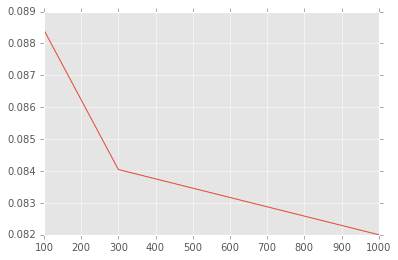

In [26]:
plt.plot(n_trees, scores)
plt.show()

# 0.100727960829

In [27]:
# Test submit

# test_data_num = test_data[num_cols]
# test_data_num.fillna(0, inplace=True)
# test_data_num = prepare_num_data(test_data_num)
real_pred = clf.predict(test_ready)

ans = pd.DataFrame()
ans['id'] = test_data.index.copy()
ans['prime_tot_ttc'] = real_pred

ans.to_csv('test_ans.csv', index=False, sep=';')

## Dealing with Categorical variables

In [7]:
data_cat.head(2)

,marque,energie_veh,profession,var6,var7,var8,var14,var16
id,,,,,,,,
1,80,4,9,0,1,1,7,1
2,80,4,9,1,15,4,7,1


In [91]:
data_cat.head(2)

,marque,energie_veh,profession,var6,var7,var8,var14,var16
id,,,,,,,,
1,117,4,9,0,1,1,7,1
2,117,4,9,1,15,4,7,1
